<a href="https://colab.research.google.com/github/vit050587/neural_networks/blob/master/KVA_INN_HW_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Решение домашнего задания к уроку 5. Рекуррентные нейронные сети

Используя файл Web5.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [51]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU

In [2]:
tf.random.set_seed(1)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O airline-passengers.csv

--2023-04-24 16:19:23--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Resolving drive.google.com (drive.google.com)... 74.125.126.139, 74.125.126.138, 74.125.126.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.126.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/stdct7qt738cmfqrtsv5kvpkhnt6ubgg/1682353125000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=35ba3628-6a9a-4cc9-b265-7206a24c77d2 [following]
--2023-04-24 16:19:23--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/stdct7qt738cmfqrtsv5kvpkhnt6ubgg/1682353125000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download&uuid=35ba3628-6a9a-4cc9-b265-7206a24c77d2
Resolving doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)... 108.177.112.132, 2607

In [5]:
airline_passengers_data = pd.read_csv('/content/airline-passengers.csv')

In [6]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [8]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

Распарсим дату

In [9]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [10]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [11]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

Отбросим первый столбец, т.к. признаки [year, mon] его представляют.

In [12]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Разбиваем выборку на обучение и на тест.

In [13]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

Создаем данные для обучения

In [14]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [15]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [16]:
# длина истории
x_len = 3

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [17]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

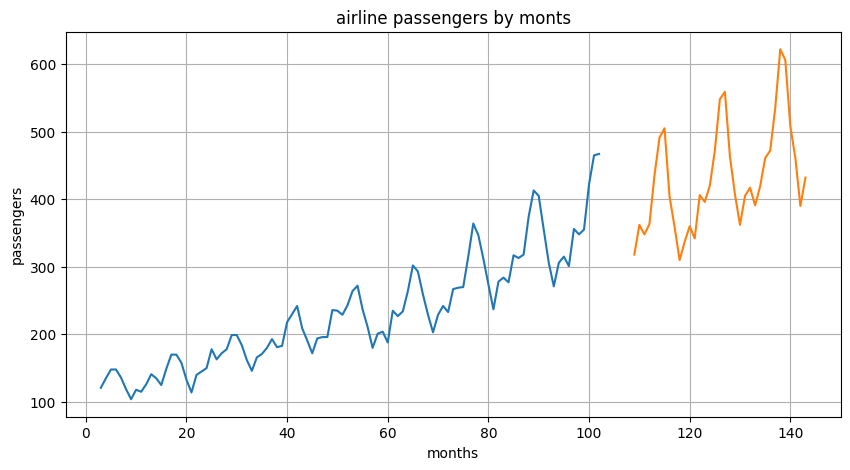

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [20]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [21]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [22]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

**SimpleRNN**

In [23]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-traina

In [24]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 18s 48ms/step - loss: 57211.5781 - mae: 226.3882 - val_loss: 196407.3281 - val_mae: 435.8730
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 56477.7344 - mae: 224.8610 - val_loss: 193747.8750 - val_mae: 432.8753
Epoch 3/10
13/13 [==============================] - 0s 12ms/step - loss: 56184.2383 - mae: 224.5961 - val_loss: 191404.8750 - val_mae: 430.2247
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 55684.0859 - mae: 223.9280 - val_loss: 187696.9219 - val_mae: 426.0059
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 54494.6055 - mae: 222.1185 - val_loss: 179561.4844 - val_mae: 416.5921
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 51348.7695 - mae: 216.8881 - val_loss: 160248.7656 - val_mae: 393.2615
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 43093.7656 - mae: 201.1049 - val_loss: 117636.0938 - val_mae: 

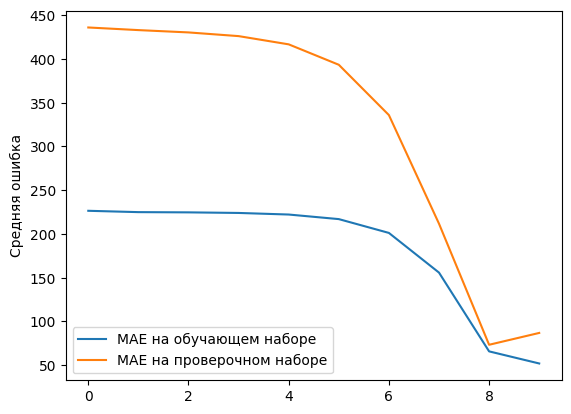

In [25]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [26]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [27]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 1479.0415 - mae: 28.9687 - val_loss: 18317.2461 - val_mae: 115.8643
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 1169.0874 - mae: 26.6797 - val_loss: 12301.6768 - val_mae: 90.2364
Epoch 3/10
13/13 [==============================] - 0s 17ms/step - loss: 1254.2843 - mae: 28.1302 - val_loss: 12076.2012 - val_mae: 89.8866
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 1125.9711 - mae: 26.8110 - val_loss: 12604.9551 - val_mae: 92.9057
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 1077.7222 - mae: 26.1150 - val_loss: 11771.3613 - val_mae: 88.8363
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 1035.3939 - mae: 25.3957 - val_loss: 11557.2480 - val_mae: 87.9659
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 986.9745 - mae: 24.8404 - val_loss: 11268.1113 - val_mae: 86.8644
Epoch 8/10
13/13 [==

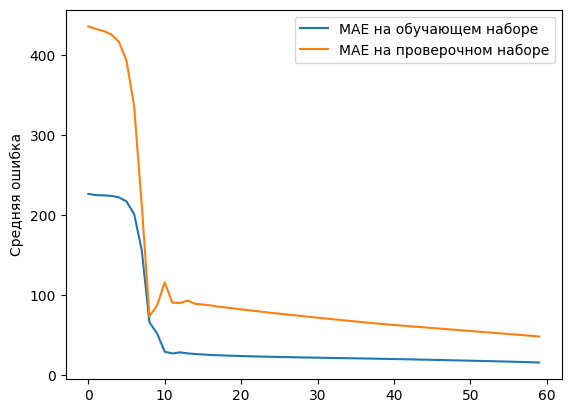

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 359.6723 - mae: 15.1526 - val_loss: 3980.8271 - val_mae: 47.2218
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 345.0555 - mae: 14.8443 - val_loss: 3882.9766 - val_mae: 46.4458
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 330.3696 - mae: 14.5335 - val_loss: 3786.9944 - val_mae: 45.6688
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 315.7219 - mae: 14.2140 - val_loss: 3693.0610 - val_mae: 44.8925
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 301.2288 - mae: 13.8839 - val_loss: 3601.4175 - val_mae: 44.1190
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 287.0080 - mae: 13.5444 - val_loss: 3512.3428 - val_mae: 43.3507
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 273.1741 - mae: 13.1969 - val_loss: 3426.1182 - val_mae: 42.6115
Epoch 8/10
13/13 [================

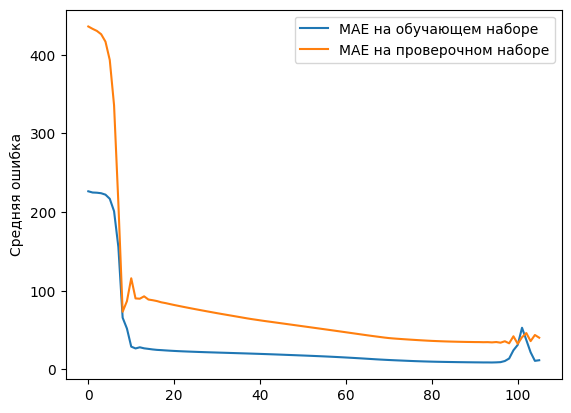

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 167.2144 - mae: 10.5212 - val_loss: 3010.2961 - val_mae: 39.0601
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 168.2007 - mae: 10.3254 - val_loss: 3131.9824 - val_mae: 39.7975
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 145.6983 - mae: 9.7654 - val_loss: 2952.2556 - val_mae: 38.6568
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 154.4028 - mae: 9.8697 - val_loss: 2961.0815 - val_mae: 38.6441
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 141.1912 - mae: 9.6443 - val_loss: 2841.2678 - val_mae: 37.8738
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 143.9560 - mae: 9.5675 - val_loss: 2855.9724 - val_mae: 37.9125
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 134.5476 - mae: 9.3824 - val_loss: 2749.2329 - val_mae: 37.1755
Epoch 8/10
13/13 [=====================

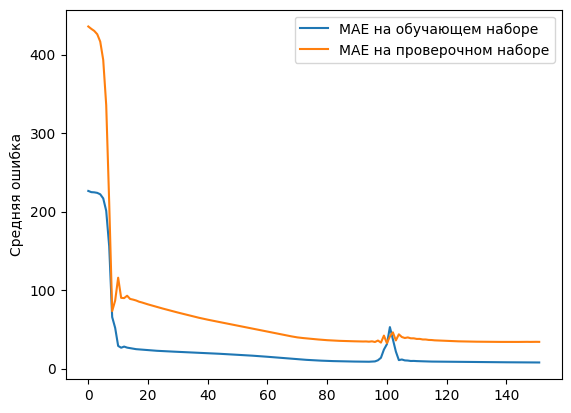

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 100.4158 - mae: 7.8784 - val_loss: 2148.9229 - val_mae: 34.3178
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 101.0286 - mae: 7.8967 - val_loss: 2137.5342 - val_mae: 34.0822
Epoch 3/10
13/13 [==============================] - 0s 15ms/step - loss: 101.7642 - mae: 7.8649 - val_loss: 2171.9580 - val_mae: 34.3759
Epoch 4/10
13/13 [==============================] - 0s 19ms/step - loss: 102.7933 - mae: 7.9884 - val_loss: 2095.9968 - val_mae: 34.1579
Epoch 5/10
13/13 [==============================] - 0s 23ms/step - loss: 104.6409 - mae: 7.9305 - val_loss: 2194.2544 - val_mae: 34.2798
Epoch 6/10
13/13 [==============================] - 0s 26ms/step - loss: 102.0506 - mae: 7.9674 - val_loss: 2081.8630 - val_mae: 34.3930
Epoch 7/10
13/13 [==============================] - 0s 24ms/step - loss: 102.0228 - mae: 7.8258 - val_loss: 2173.5784 - val_mae: 34.0776
Epoch 8/10
13/13 [=======================

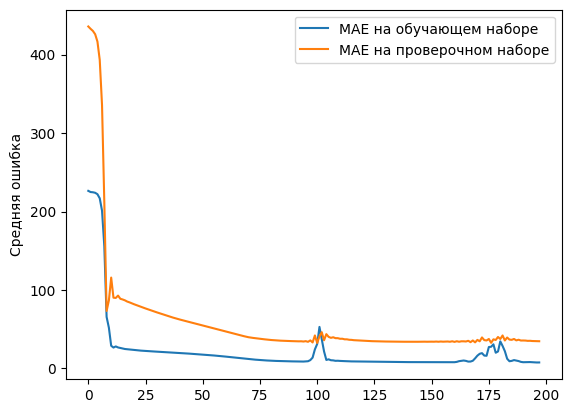

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 97.5900 - mae: 7.7473 - val_loss: 2350.2192 - val_mae: 34.6416
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 96.1310 - mae: 7.6755 - val_loss: 2317.7207 - val_mae: 34.6521
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 94.8642 - mae: 7.6793 - val_loss: 2303.7219 - val_mae: 34.5081
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 93.7236 - mae: 7.4985 - val_loss: 2302.5200 - val_mae: 34.5224
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 92.8654 - mae: 7.5763 - val_loss: 2270.0059 - val_mae: 34.4625
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 94.5629 - mae: 7.6009 - val_loss: 2271.9385 - val_mae: 34.3595
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 93.7365 - mae: 7.5449 - val_loss: 2259.1919 - val_mae: 34.4259
Epoch 8/10
13/13 [==============================

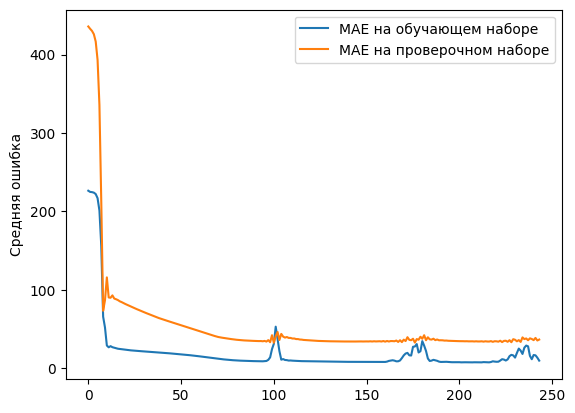

In [28]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [29]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 4ms/step


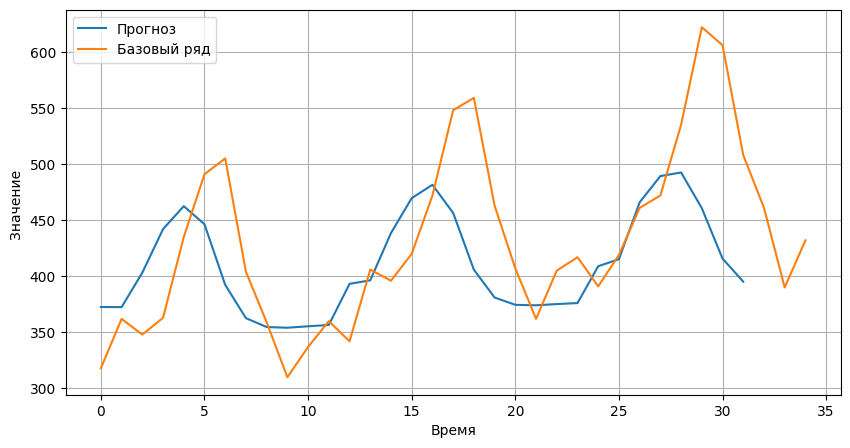

In [30]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

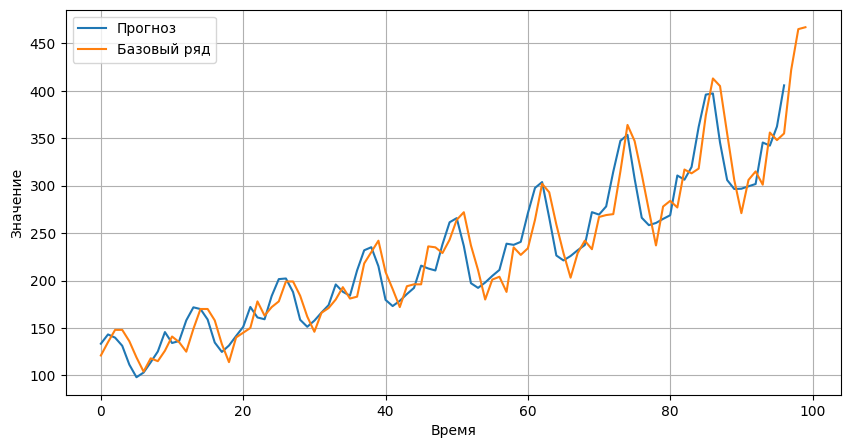

In [31]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [32]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 4ms/step - loss: 2637.1038 - mae: 36.5612
train_loss: 91.02174377441406, train_m: 7.490076065063477
test_loss: 2637.103759765625, test_m: 36.5611686706543


**LSTM**

In [33]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [34]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 7s 81ms/step - loss: 56642.6055 - mae: 225.6090 - val_loss: 193058.2188 - val_mae: 432.0617
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 56288.7695 - mae: 224.8667 - val_loss: 191943.1250 - val_mae: 430.7789
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 55168.7188 - mae: 222.6210 - val_loss: 187612.5781 - val_mae: 425.7817
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 51169.0625 - mae: 214.5112 - val_loss: 171102.9062 - val_mae: 406.2510
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 38475.1367 - mae: 186.5950 - val_loss: 117577.8984 - val_mae: 335.4201
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 11116.6123 - mae: 99.9568 - val_loss: 20141.1758 - val_mae: 128.8191
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 3331.4160 - mae: 45.4426 - val_loss: 3880.5869 - val_mae: 46.6549

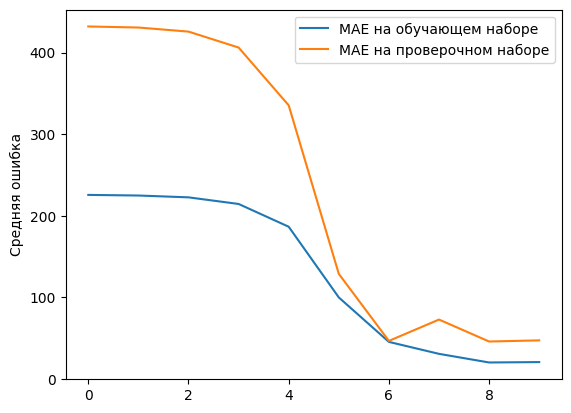

In [35]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [36]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [37]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 680.2891 - mae: 19.8565 - val_loss: 4470.6304 - val_mae: 48.4867
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 674.0356 - mae: 19.8446 - val_loss: 4141.6445 - val_mae: 46.6286
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 661.4896 - mae: 19.5790 - val_loss: 4346.4673 - val_mae: 47.8178
Epoch 4/10
13/13 [==============================] - 0s 13ms/step - loss: 659.4585 - mae: 19.6301 - val_loss: 4171.5864 - val_mae: 46.7663
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 656.1118 - mae: 19.5804 - val_loss: 4180.3813 - val_mae: 46.8130
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 654.3649 - mae: 19.5800 - val_loss: 4101.9131 - val_mae: 46.3543
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 652.0460 - mae: 19.5533 - val_loss: 4072.1577 - val_mae: 46.2020
Epoch 8/10
13/13 [================

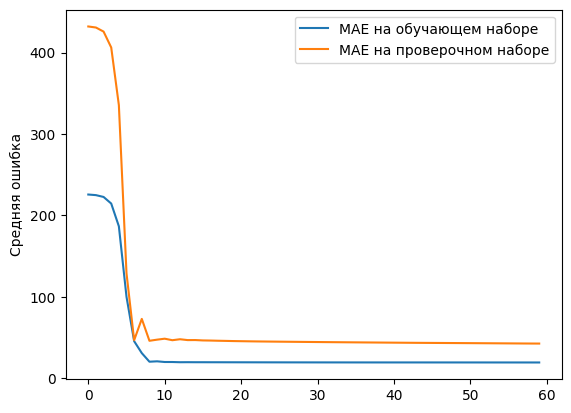

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 602.2690 - mae: 19.2645 - val_loss: 3207.9841 - val_mae: 42.4580
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 601.2516 - mae: 19.2575 - val_loss: 3196.0022 - val_mae: 42.4130
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 600.2125 - mae: 19.2499 - val_loss: 3183.9297 - val_mae: 42.3662
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 599.1506 - mae: 19.2415 - val_loss: 3171.7573 - val_mae: 42.3173
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 598.0636 - mae: 19.2323 - val_loss: 3159.4724 - val_mae: 42.2664
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 596.9497 - mae: 19.2223 - val_loss: 3147.0615 - val_mae: 42.2132
Epoch 7/10
13/13 [==============================] - 0s 13ms/step - loss: 595.8069 - mae: 19.2114 - val_loss: 3134.5188 - val_mae: 42.1576
Epoch 8/10
13/13 [================

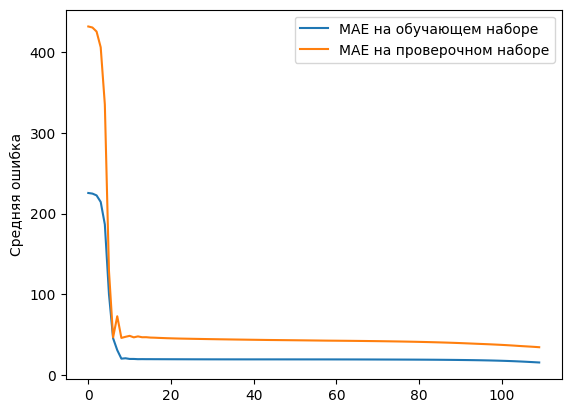

Epoch 1/10
13/13 [==============================] - 0s 13ms/step - loss: 362.4859 - mae: 15.1667 - val_loss: 1984.0835 - val_mae: 34.0195
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 345.1253 - mae: 14.8397 - val_loss: 1926.0548 - val_mae: 33.6084
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 327.3853 - mae: 14.4833 - val_loss: 1866.9172 - val_mae: 33.1754
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 309.4996 - mae: 14.1052 - val_loss: 1807.0033 - val_mae: 32.7327
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 291.7332 - mae: 13.7036 - val_loss: 1746.7373 - val_mae: 32.3235
Epoch 6/10
13/13 [==============================] - 0s 16ms/step - loss: 274.3717 - mae: 13.2785 - val_loss: 1686.6758 - val_mae: 31.9066
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 257.7019 - mae: 12.8607 - val_loss: 1627.4949 - val_mae: 31.4788
Epoch 8/10
13/13 [================

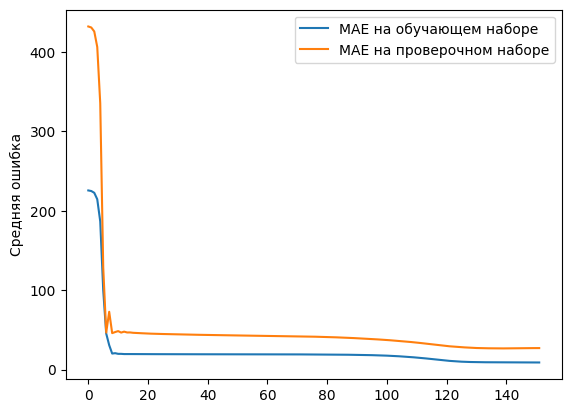

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 134.0411 - mae: 8.9635 - val_loss: 1018.8290 - val_mae: 27.1438
Epoch 2/10
13/13 [==============================] - 0s 13ms/step - loss: 133.5164 - mae: 8.9496 - val_loss: 1024.4468 - val_mae: 27.2562
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 133.3342 - mae: 8.9461 - val_loss: 1028.3872 - val_mae: 27.3387
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 133.3945 - mae: 8.9403 - val_loss: 1024.5719 - val_mae: 27.2871
Epoch 5/10
13/13 [==============================] - 0s 13ms/step - loss: 133.1970 - mae: 8.9153 - val_loss: 1020.2192 - val_mae: 27.2135
Epoch 6/10
13/13 [==============================] - 0s 13ms/step - loss: 132.2282 - mae: 8.8860 - val_loss: 1027.8127 - val_mae: 27.3393
Epoch 1/10
13/13 [==============================] - 0s 15ms/step - loss: 131.8616 - mae: 8.8934 - val_loss: 1045.0807 - val_mae: 27.6145
Epoch 2/10
13/13 [=======================

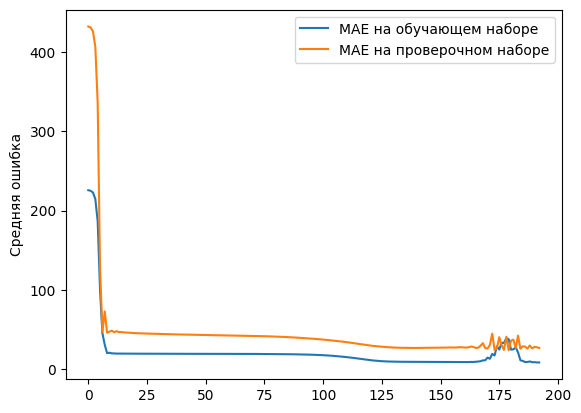

Epoch 1/10
13/13 [==============================] - 0s 14ms/step - loss: 120.9190 - mae: 8.5916 - val_loss: 1087.8929 - val_mae: 28.1841
Epoch 2/10
13/13 [==============================] - 0s 14ms/step - loss: 120.4298 - mae: 8.3163 - val_loss: 986.1247 - val_mae: 26.7443
Epoch 3/10
13/13 [==============================] - 0s 13ms/step - loss: 118.2042 - mae: 8.4168 - val_loss: 1056.3470 - val_mae: 27.6614
Epoch 4/10
13/13 [==============================] - 0s 15ms/step - loss: 118.1255 - mae: 8.3429 - val_loss: 1032.2908 - val_mae: 27.4403
Epoch 5/10
13/13 [==============================] - 0s 15ms/step - loss: 117.6252 - mae: 8.2714 - val_loss: 1012.8449 - val_mae: 27.0582
Epoch 6/10
13/13 [==============================] - 0s 14ms/step - loss: 117.4794 - mae: 8.3822 - val_loss: 1059.7379 - val_mae: 27.7462
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 117.2695 - mae: 8.2430 - val_loss: 1012.5641 - val_mae: 27.0893
Epoch 1/10
13/13 [========================

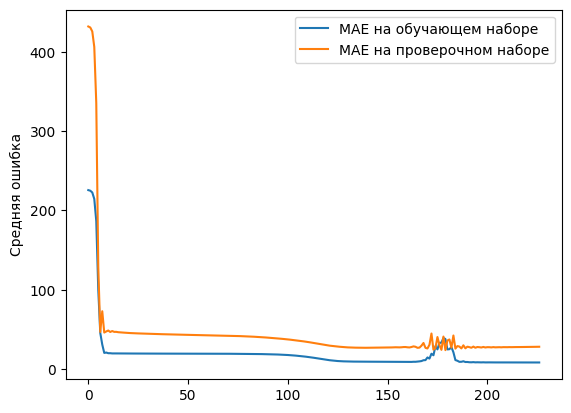

In [38]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [39]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 8ms/step


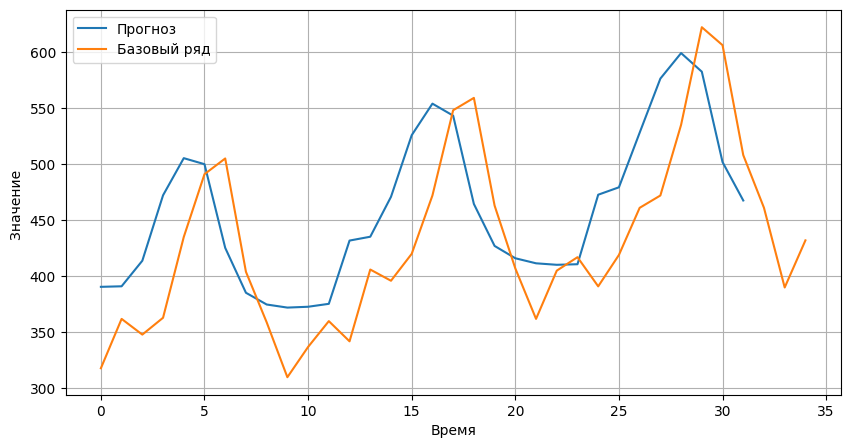

In [40]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

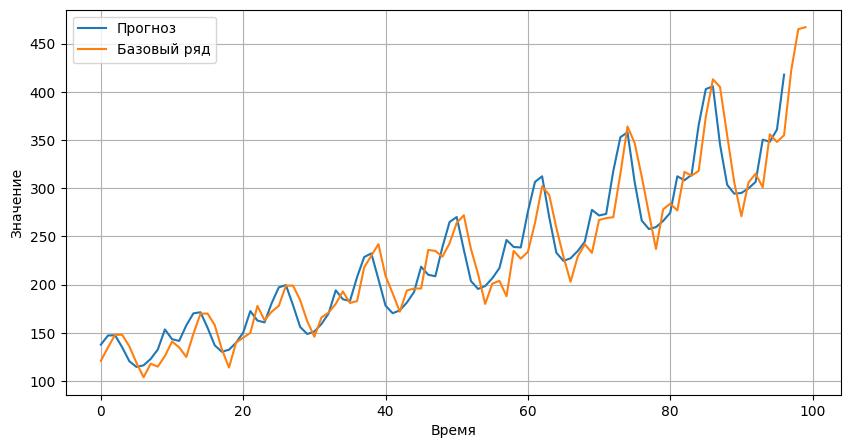

In [41]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [42]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 5ms/step - loss: 1097.4590 - mae: 27.9930
train_loss: 101.84675598144531, train_m: 7.7012858390808105
test_loss: 1097.458984375, test_m: 27.99303436279297


Общий результат

In [53]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [54]:
results

,model,train_m,test_m
0,SimpleRNN,7.49,36.56
1,LSTM,7.70,27.99


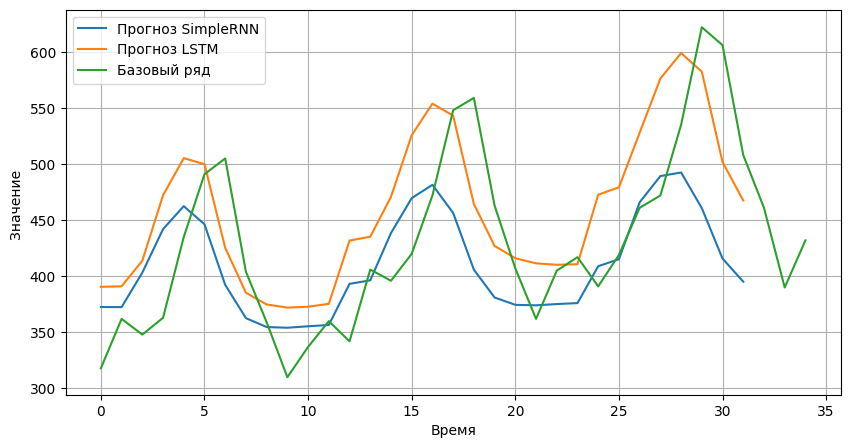

In [56]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')

plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

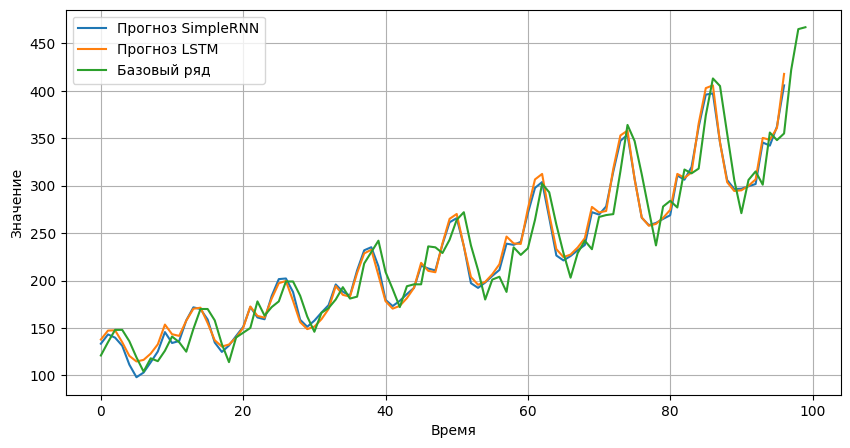

In [58]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

**Выводы:<br>**

* чем больше итераций - тем выше качество (25 и правда хватает)
* для данного датасета лучше справился LSTM 